In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize

import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import math
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.datasets import load_files
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from statsmodels.tools.eval_measures import mse, rmse
from wordcloud import WordCloud
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn import tree
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn import neighbors
from IPython.display import Image
from sklearn.utils import resample
from sklearn import metrics

import pydotplus
from sklearn import ensemble

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')
import time
import cv2
import glob

Using TensorFlow backend.


In [29]:
#importing the data

df_app_events = (pd.read_csv('Data/talkingdata/app_events.csv'))

df_app_labels = (pd.read_csv('Data/talkingdata/app_labels.csv'))

df_events = (pd.read_csv('Data/talkingdata/events.csv'))

df_gender_age_train = (pd.read_csv('Data/talkingdata/gender_age_train.csv'))

df_label_categories = (pd.read_csv('Data/talkingdata/label_categories.csv'))

df_phone_brand_device_model = (pd.read_csv('Data/talkingdata/phone_brand_device_model.csv'))

# Gender Classification by App Usage Data
### by Jason Olavesen

## Introduction

Is it possible to predict a user's demographic data based on their app downloads, app usage behavior, and geolocation?  Such an ability would allow developers and brand advertisers to customize their efforts and offerings to the preferences and needs of each user.  In this project, we predict the gender of a user based on exactly those variables.  The dataset was made available by TalkingData, China’s largest third-party mobile data platform, and can be found here: https://www.kaggle.com/c/talkingdata-mobile-user-demographics/overview. 

## Data Exploration

- This data set comes organized in a conceptual heirarchy of dataframes, with the target variable at the top, as well as a unique id number ('device_id') representing a specific cell phone which is leveraged by TalkingData.  The bottom of the heirarchy includes variables like app category (e.g. gaming, navigation, etc) and phone brand.  The cells below are arranged in this concept order, and the variables listed under each one illustrate the steps required to associate a variable at the top of the heirarchy with a variable at the bottom.  
- For example, a 'device_id' selected from the first dataframe (df_gender_age_train) is associated with one or more 'event_id' values in the next dataframe (df_events).  In the subsequent dataframe (df_app_events), 'event_id' values are associated with one or more 'app_id' values, and finally the next dataframe (df_app_labels) associates 'app_id' values with one or more 'label_id' values.  To deal with this complexity and prepare our feature set, we will combine the variables we want into one (very) large dataframe through a series of join operations.
- All of the id values in the data are nominal integers.

In [16]:
df_gender_age_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
device_id    74645 non-null int64
gender       74645 non-null object
age          74645 non-null int64
group        74645 non-null object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [15]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
event_id     int64
device_id    int64
timestamp    object
longitude    float64
latitude     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 124.1+ MB


In [13]:
df_app_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
event_id        int64
app_id          int64
is_installed    int64
is_active       int64
dtypes: int64(4)
memory usage: 991.0 MB


In [14]:
df_app_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459943 entries, 0 to 459942
Data columns (total 2 columns):
app_id      459943 non-null int64
label_id    459943 non-null int64
dtypes: int64(2)
memory usage: 7.0 MB


In [17]:
df_label_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 2 columns):
label_id    930 non-null int64
category    927 non-null object
dtypes: int64(1), object(1)
memory usage: 14.6+ KB


In [18]:
df_phone_brand_device_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187245 entries, 0 to 187244
Data columns (total 3 columns):
device_id       187245 non-null int64
phone_brand     187245 non-null object
device_model    187245 non-null object
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


## Feature Engineering

- The "df_phone_brand_device_model" data frame includes the variables 'phone_brand' and 'device_model' which both contain Chinese characters as shown below.  Here we use a string encoder called 'unicode-escape' to convert them into python friendly strings.
- The converted strings can be used as dummy variables in our feature set.

In [30]:
#create new variable to store the converted strings
df_phone_brand_device_model['encoded_model'] = None
df_phone_brand_device_model['encoded_brand'] = None

In [31]:
#convert the strings
df_phone_brand_device_model['encoded_model'] = df_phone_brand_device_model['device_model'].apply(lambda x: x.encode('unicode-escape'))
df_phone_brand_device_model['encoded_brand'] = df_phone_brand_device_model['phone_brand'].apply(lambda x: x.encode('unicode-escape'))

In [32]:
df_phone_brand_device_model.head(5)

,device_id,phone_brand,device_model,encoded_model,encoded_brand
0,-8890648629457979026,小米,红米,b'\\u7ea2\\u7c73',b'\\u5c0f\\u7c73'
1,1277779817574759137,小米,MI 2,b'MI 2',b'\\u5c0f\\u7c73'
2,5137427614288105724,三星,Galaxy S4,b'Galaxy S4',b'\\u4e09\\u661f'
3,3669464369358936369,SUGAR,时尚手机,b'\\u65f6\\u5c1a\\u624b\\u673a',b'SUGAR'
4,-5019277647504317457,三星,Galaxy Note 2,b'Galaxy Note 2',b'\\u4e09\\u661f'


### Feature Engineering (continued)

- The "df_events" dataframe contains latitudinal and longitudinal data as two separate variables.  To combine them into one useful feature, we will implement the Haversine formula (essentially the distance formula for spherical surfaces) and store the result in a new variable.

In [35]:
#combine lat and long into haversine distance
df_events['haversine_distance'] = [haversine_to_origin(x, y) for x, y in zip(df_events.latitude, df_events.longitude)]

In [36]:
df_events.head(2)

,event_id,device_id,timestamp,longitude,latitude,haversine_distance
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,12947.176657
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,11305.657658


## Feature Engineering (continued)

- The "df_events" dataframe also contains a timestamp variable.  Time of day seems intuitively more relevant than calendar date with respect to app usage, so here we create a convenient feature that bins each timestamp into its respective hour.

In [37]:
df_events['time_hour'] = pd.to_datetime(df_events['timestamp']).dt.hour

In [38]:
df_events['time_hour'].value_counts()

10    183839
21    181175
20    178179
22    168246
11    167025
19    166160
9     166061
12    162745
8     157896
18    156209
13    155337
17    153516
14    151379
16    150732
15    149912
7     146667
23    136339
0     120512
6     116370
1      72671
5      66411
2      53764
3      47048
4      44757
Name: time_hour, dtype: int64

### Feature Engineering (continued)

- Here we convert our target variable 'gender' to binary, and the 'group' variable to numeric (we will use this group variable in our unsupervised analysis). 

In [39]:
# Convert gender into a binary output
df_gender_age_train['gender'] = df_gender_age_train['gender'].apply(lambda x: 1 if x == 'F' else 0 )

In [40]:
df_gender_age_train['gender'].value_counts()

0    47904
1    26741
Name: gender, dtype: int64

- The 'group' variable separates the genders into age brackets, as shown below.  We will use this variable in our unsupervised model.

In [41]:
df_gender_age_train['group'].value_counts()

M23-26    9605
M32-38    9476
M39+      8581
M22-      7488
M29-31    7309
F33-42    5561
M27-28    5445
F23-      5050
F29-32    4628
F43+      4194
F24-26    4190
F27-28    3118
Name: group, dtype: int64

In [42]:
#Make a numerical version of the 'group' variable
group_num = []

for idx, val in enumerate(df_gender_age_train['group']):
    if val == 'F27-28':
        group_num.append(0)
    elif val == 'F24-26':
        group_num.append(1)
    elif val == 'F43+':
        group_num.append(2)
    elif val == 'F29-32':
        group_num.append(3)
    elif val == 'F23-':
        group_num.append(4)
    elif val == 'M27-28':
        group_num.append(5)
    elif val == 'F33-42':
        group_num.append(6)
    elif val == 'M29-31':
        group_num.append(7)
    elif val == 'M22-':
        group_num.append(8)
    elif val == 'M39+':
        group_num.append(9)
    elif val == 'M32-38':
        group_num.append(10)
    elif val == 'M23-26':
        group_num.append(11)
        
df_gender_age_train['group_num'] = group_num

In [43]:
df_gender_age_train['group_num'].value_counts()

11    9605
10    9476
9     8581
8     7488
7     7309
6     5561
5     5445
4     5050
3     4628
2     4194
1     4190
0     3118
Name: group_num, dtype: int64

## Merging the Data

- Here we join the dataframes together into one large dataframe in several steps.

In [44]:
df_gender_age_train = df_gender_age_train.drop(['age'], axis=1)

In [45]:
start_time = time.time()

apps_labeled = pd.merge(df_app_labels,
                       df_app_events[['app_id', 'is_active']],
                       on='app_id').dropna().drop_duplicates()

print("--- %s seconds ---" % (time.time() - start_time))

--- 112.15651106834412 seconds ---


In [46]:
start_time = time.time()

device_apps = pd.merge(df_events,
                       df_app_events[['app_id', 'is_active', 'event_id']],
                       on='event_id').dropna().drop_duplicates()

print("--- %s seconds ---" % (time.time() - start_time))

--- 44.888741970062256 seconds ---


In [47]:
del(df_app_events, df_app_labels, df_events)

In [48]:
start_time = time.time()

ga_apps = pd.merge(df_gender_age_train,
                  device_apps[['app_id', 'is_active', 'device_id', 'event_id', 'haversine_distance', 'time_hour']],
                  on='device_id').dropna().drop_duplicates()

print("--- %s seconds ---" % (time.time() - start_time))

--- 16.55095410346985 seconds ---


In [49]:
del(df_gender_age_train, device_apps)

In [50]:
start_time = time.time()

ga_apps_brands = pd.merge(ga_apps,
                         df_phone_brand_device_model[['device_id', 'encoded_brand']],
                         on='device_id').dropna().drop_duplicates()


print("--- %s seconds ---" % (time.time() - start_time))

--- 17.409013986587524 seconds ---


In [51]:
del(ga_apps, df_phone_brand_device_model)

In [52]:
start_time = time.time()

ga_apps_labeled_brands = pd.merge(ga_apps_brands,
                                 apps_labeled[['app_id', 'label_id']],
                                 on='app_id').dropna().drop_duplicates()



print("--- %s seconds ---" % (time.time() - start_time))

--- 443.255215883255 seconds ---


In [53]:
del(ga_apps_brands, apps_labeled)

- This final dataframe is fairly large, occupying over 7 GB in memory.  It also has a class imbalance of roughly 3:1 (M:F) in the target variable.  Here we do some downsampling to get the data into a manageable size and balance our target classes.

In [54]:
ga_apps_labeled_brands.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78360118 entries, 0 to 154039970
Data columns (total 11 columns):
device_id             int64
gender                int64
group                 object
group_num             int64
app_id                int64
is_active             int64
event_id              int64
haversine_distance    float64
time_hour             int64
encoded_brand         object
label_id              int64
dtypes: float64(1), int64(8), object(2)
memory usage: 7.0+ GB


In [55]:
df_smaller = ga_apps_labeled_brands.sample(frac=0.02, random_state=1)

In [56]:
df_smaller.gender.value_counts()

0    1165725
1     401477
Name: gender, dtype: int64

In [57]:
# separate minority and majority classes
df_guys = df_smaller[df_smaller.gender==0]
df_gals = df_smaller[df_smaller.gender==1]

In [58]:
# downsample majority class
df_guys_downsampled = resample(df_guys,
                                replace = False, 
                                n_samples = len(df_gals),
                                random_state = 42)

# concatenate minority and downsampled majority
df_smaller_downsampled = pd.concat([df_guys_downsampled, df_gals])

- Our downsampled dataframe, while still sizable, is much more manageable for our local computing environment, and has the target class balanced at 1:1.

In [59]:
df_smaller_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802954 entries, 90661971 to 19018624
Data columns (total 11 columns):
device_id             802954 non-null int64
gender                802954 non-null int64
group                 802954 non-null object
group_num             802954 non-null int64
app_id                802954 non-null int64
is_active             802954 non-null int64
event_id              802954 non-null int64
haversine_distance    802954 non-null float64
time_hour             802954 non-null int64
encoded_brand         802954 non-null object
label_id              802954 non-null int64
dtypes: float64(1), int64(8), object(2)
memory usage: 73.5+ MB


In [60]:
del(ga_apps_labeled_brands)

In [61]:
df_smaller_downsampled.to_csv(path_or_buf='Data/talkingdata/df_smaller_downsampled.csv')
#df_smaller_downsampled=(pd.read_csv('Data/talkingdata/these_features.csv'))

## Data Visualization

- Now that we have our data in a workable form, let's take a look at it.
- These figures provide some interesting insights concerning the frequency of certain apps and categories, and the usage habits of the most frequent users.  The devices of the most active users register several thousand entries, and the most popular apps appear in tens of thousands of entries. 

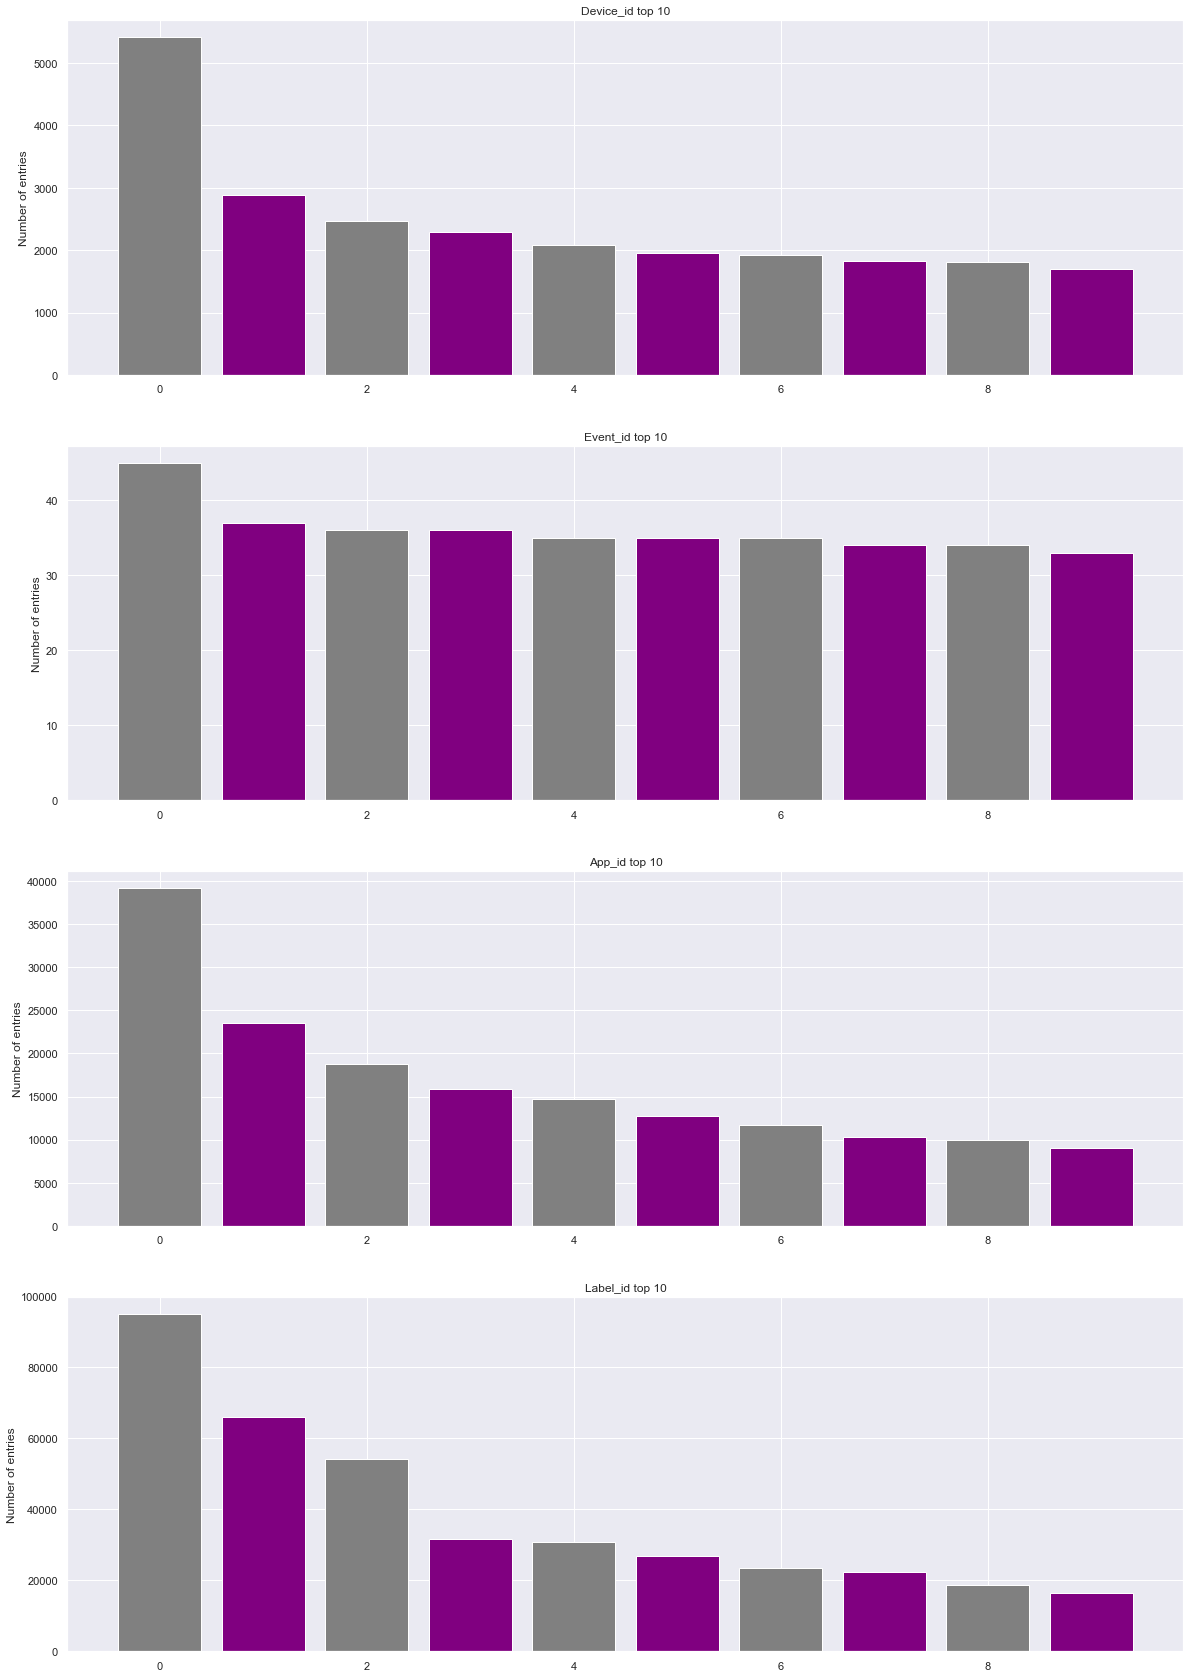

In [114]:
plt.figure(figsize=(20,30))

plt.subplot(4,1,1)
plt.title("Device_id top 10")
plt.ylabel('Number of entries')
plt.bar(np.arange(10), df_smaller_downsampled['device_id'].value_counts().head(10), color=("grey","purple"))

plt.subplot(4,1,2)
plt.title("Event_id top 10")
plt.ylabel('Number of entries')
plt.bar(np.arange(10), df_smaller_downsampled['event_id'].value_counts().head(10), color=("grey","purple"))

plt.subplot(4,1,3)
plt.title("App_id top 10")
plt.ylabel('Number of entries')
plt.bar(np.arange(10), df_smaller_downsampled['app_id'].value_counts().head(10), color=("grey","purple"))

plt.subplot(4,1,4)
plt.title("Label_id top 10")
plt.ylabel('Number of entries')
plt.bar(np.arange(10), df_smaller_downsampled['label_id'].value_counts().head(10), color=("grey","purple"))

plt.show()

- The histogram of haversine distance indicates that most of the TalkingData users live in two distinct but relatively contained geogrpahical areas (e.g. China).  The histogram of the time feature shows that only a small minority of people are active on their devices from 3-4 AM, contrasted with the greatest hour or so of activity from 8-9 AM.

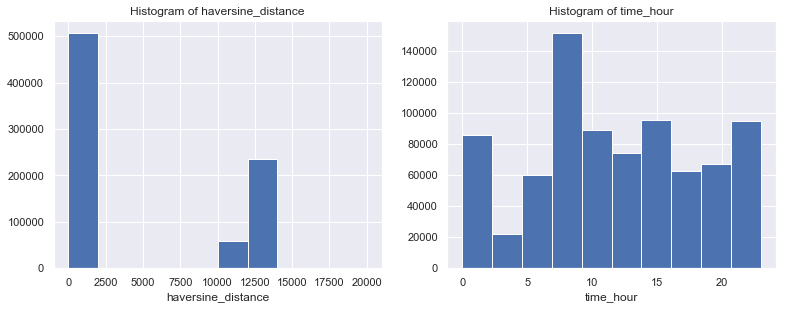

In [117]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(df_smaller_downsampled.haversine_distance)
plt.title("Histogram of {}".format("haversine_distance"))
plt.xlabel('haversine_distance')

plt.subplot(2,3,2)
plt.hist(df_smaller_downsampled.time_hour)
plt.title("Histogram of {}".format("time_hour"))
plt.xlabel('time_hour')

plt.show()

- Here, we use a heatmap to check the correlations of the various features with each other and with the target variable.

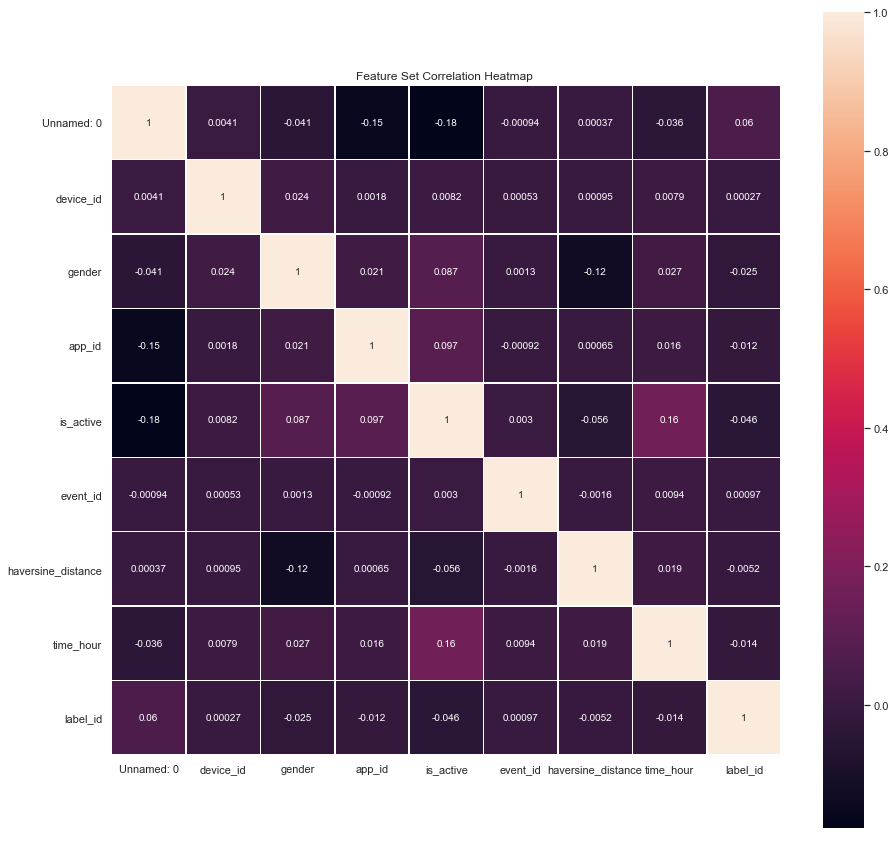

In [4]:
plt.figure(figsize=(15,15))

sns.heatmap(df_smaller_downsampled.select_dtypes(['int64', 'float64']).corr(), square=True, annot=True, linewidths=.5)
plt.title("Feature Set Correlation Heatmap ")

plt.show()

In [104]:
#check the correlation of various features with the target

np.abs(df_smaller_downsampled[
    df_smaller_downsampled.select_dtypes([
        'int64', 'float64']).columns].iloc[:,1:].corr().loc[:,'gender']).sort_values(ascending=False)


gender                1.000000
haversine_distance    0.123080
is_active             0.086999
time_hour             0.026926
label_id              0.024670
app_id                0.020519
event_id              0.001316
Name: gender, dtype: float64

- None of the variables show much correlation.

In [106]:
#double checking for missing values in the data

missing_values_ratios = (df_smaller_downsampled.isnull().sum()/df_smaller_downsampled.isnull().count())
missing_values_ratios.sort_values(ascending=False).head()

label_id              0.0
encoded_brand         0.0
time_hour             0.0
haversine_distance    0.0
event_id              0.0
dtype: float64

## Feature Engineering (cont)

- Here we choose our features, normalize the data, apply PCA, and split the data into testing and training sets to prepare the data for the models.

In [62]:
#make dummies from the 'encoded_brand' variable to use in the feature set
brand_dummies = pd.get_dummies(df_smaller_downsampled[['encoded_brand']], drop_first=True)

In [63]:
X = pd.concat([df_smaller_downsampled[['device_id', 'app_id', 'is_active', 'label_id', 'event_id', 
                            'haversine_distance', 'time_hour']], brand_dummies], axis=1)

y = df_smaller_downsampled['gender']

y_2 = df_smaller_downsampled['group_num']

- Preparing the data for PCA

In [64]:
X_norm = normalize(X)

In [65]:
Xt = X_norm.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

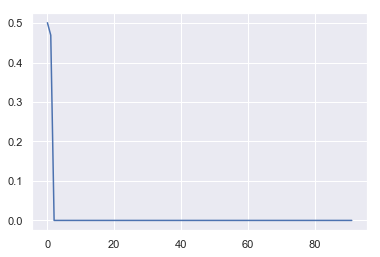

[5.00710990e-01 4.69145926e-01 4.45622943e-25 6.76724868e-30
 2.25997911e-32 9.45168645e-36 3.14142949e-38 5.14214788e-38
 2.70281190e-38 1.65501930e-38]


In [38]:
# view scree plot to evaluate n_components for PCA
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov[0:10])

- Most of the variance is explained by only two components

In [66]:
start_time = time.time()

sklearn_pca = PCA(n_components=2)  
X_pca = sklearn_pca.fit_transform(X_norm)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA:\n',
    sklearn_pca.explained_variance_ratio_
)

print("--- %s seconds ---" % (time.time() - start_time))

The percentage of total variance in the dataset explained by each component from Sklearn PCA:
 [0.51627305 0.48372695]
--- 3.3713951110839844 seconds ---


In [67]:
# Split the data into four equally-sized samples for analysis with silhouette. 

X_pcahalf1, X_pcahalf2 = train_test_split(
    X_pca,
    test_size=0.5,
    random_state=42)
X_pca1, X_pca2 = train_test_split(
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X_pca3, X_pca4 = train_test_split(
    X_pcahalf2,
    test_size=0.5,
   random_state=42)

In [68]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test, y_2_train, y_2_test = train_test_split(
    X_pca,
    y,
    y_2,
    test_size=0.2,
    random_state=1)

# Supervised Models

## Model 1: Decision Tree

- Decision Trees are a good choice for classification problems, and don't make any assumptions about the data.  This makes them a good benchmark choice for this project.
- We used GridSearchCV for choosing hyperparameters on this and subsequent models that require them.

In [13]:
#setting up parameters for GridSearchCV(DecisionTreeClassifier())

depths = np.arange(1, 10)
num_features = [1, 2]

param_grid_dt_pca = [{'decisiontreeclassifier__max_depth':depths,
               'decisiontreeclassifier__max_features':num_features}]

pipe_tree_dt_pca = make_pipeline(tree.DecisionTreeClassifier(criterion='entropy'))

In [14]:
start_time = time.time()

gs_dt_pca = GridSearchCV(pipe_tree_dt_pca, param_grid=param_grid_dt_pca, cv=5)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00019598007202148438 seconds ---


In [15]:
start_time = time.time()

gs_dt_pca.fit(X_train,y_train)
print(gs_dt_pca.best_params_)

print("--- %s seconds ---" % (time.time() - start_time))

{'decisiontreeclassifier__max_depth': 9, 'decisiontreeclassifier__max_features': 2}


In [136]:
#initialize and train the decision tree model using GridSearchCV results
start_time = time.time()

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=2,
    max_depth=9
)

decision_tree.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.1042330265045166 seconds ---


In [137]:
#making predictions for model evaluation

start_time = time.time()

y_pred_dt = decision_tree.fit(X_train, y_train).predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.36745023727417 seconds ---


In [138]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(decision_tree, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(decision_tree, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.53202059 0.52973736 0.52768937 0.52666538 0.52589046 0.53089973
 0.52991725 0.53269864 0.53209714 0.53421435]
The 10-fold cross validation average for the training set is  0.5300723182926923
--- 40.03949522972107 seconds ---


In [140]:
#classification report

print(classification_report(y_test, y_pred_dt, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.52      0.60      0.56     40089
           1       0.53      0.45      0.49     40207

    accuracy                           0.53     80296
   macro avg       0.53      0.53      0.53     80296
weighted avg       0.53      0.53      0.53     80296



In [141]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_pred_dt, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[24160 15929]
 [21982 18225]]


- Our decision tree performed as a classifier only a few percentage points better than a coin toss.

## Model 2: Naive Bayes

- Naive Bayes models, while simple, fast, and intuitve, prefer normally distributed data, so it's not a big surprise that it doesn't show very good performance here.  This is our weakest classifier.

In [74]:
start_time = time.time()

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(X_train, y_train)

# Classify, storing the result in a new variable.
y_preds_nb = bnb.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.18696928024291992 seconds ---


In [75]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(bnb, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(bnb, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.51147151 0.50906374 0.51178978 0.50954806 0.51109789 0.51007389
 0.5105167  0.51064124 0.50901543 0.5093337 ]
The 10-fold cross validation average for the training set is  0.5102551937967117
--- 3.913083076477051 seconds ---


In [77]:
#classification report

print(classification_report(y_test, y_preds_nb, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.51      0.46      0.48     40237
           1       0.51      0.56      0.53     40059

    accuracy                           0.51     80296
   macro avg       0.51      0.51      0.51     80296
weighted avg       0.51      0.51      0.51     80296



In [78]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_preds_nb, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[18427 21810]
 [17471 22588]]


## Model 3: KNN

- KNN models are also intuitive and relatively simple, tend to perform well on multi-class problems, and don't make any assumptions about the distribution of the data.
- We expected good performance from KNN, and this model ended up in second place.

In [41]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
num_neighbors = np.arange(1, 20)
weights = ['distance','uniform']
leaf_sizes = np.arange(1, 5)

param_grid_knn = [{'kneighborsclassifier__n_neighbors':num_neighbors,
                      'kneighborsclassifier__weights':weights,
                      'kneighborsclassifier__leaf_size':leaf_sizes}
                     ]
pipe_tree_knn = make_pipeline(neighbors.KNeighborsClassifier())

In [42]:
start_time = time.time()

gs_knn = GridSearchCV(pipe_tree_knn, param_grid=param_grid_knn, cv=5)

print("--- %s seconds ---" % (time.time() - start_time))
#gs_knn.get_params().keys()

--- 0.00014209747314453125 seconds ---


In [43]:
start_time = time.time()

gs_knn.fit(X_train,y_train)
print(gs_knn.best_params_)

print("--- %s seconds ---" % (time.time() - start_time))

{'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 19, 'kneighborsclassifier__weights': 'uniform'}
--- 199.55490612983704 seconds ---


In [12]:
start_time = time.time()

knn = neighbors.KNeighborsClassifier(n_neighbors=19, weights='uniform', leaf_size=1)
knn.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.2875797748565674 seconds ---


In [13]:
# Classify, storing the result in a new variable.
start_time = time.time()

y_preds_knn = knn.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 8.602159261703491 seconds ---


In [14]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(knn, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(knn, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.66569111 0.67084391 0.6722761  0.67048586 0.66893954 0.67241111
 0.670543   0.67473068 0.67336073 0.6766716 ]
The 10-fold cross validation average for the training set is  0.6715953629967901
--- 109.50365686416626 seconds ---


In [15]:
#classification report

print(classification_report(y_test, y_preds_knn, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68     80308
           1       0.68      0.69      0.68     80283

    accuracy                           0.68    160591
   macro avg       0.68      0.68      0.68    160591
weighted avg       0.68      0.68      0.68    160591



In [16]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_preds_knn, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[53670 26638]
 [24610 55673]]


- KNN models, like decision trees, are intuitive and fast.  Even with this challenging data set, the KNN model shows decent classificatin performance, and is less resource intensive than our first place model, the random forest classifier.  The silver medalist!

## Model 4: SVM

- SVM models are very effective classifiers.  However, they require the tuning of several hyperparameters, and are far more resource intensive than our other models.
- Our SVM model did not classify well, but there is room for improvement and further exploration here.

In [50]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [1,2,3]
param_grid_svm = [{'svc__degree':degrees}]
pipe_tree_svm = make_pipeline(SVC(kernel = 'poly'))

In [51]:
start_time = time.time()

gs_svm = GridSearchCV(pipe_tree_svm, param_grid=param_grid_svm, cv=5)

#gs_svm.get_params().keys()
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00011610984802246094 seconds ---


In [52]:
start_time = time.time()

gs_svm.fit(X_train,y_train)
print(gs_svm.best_params_)

print("--- %s seconds ---" % (time.time() - start_time))

{'svc__degree': 1}
--- 185.38452196121216 seconds ---


{'svc__degree': 1}
--- 185.38452196121216 seconds ---

In [9]:
start_time = time.time()

svm = SVC(kernel='poly',degree=1)
svm.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 11176.421251058578 seconds ---


In [10]:
start_time = time.time()

#Setting the predictions for analysis
y_pred_svm = svm.fit(X_train, y_train).predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 12423.343416929245 seconds ---


In [ ]:
# #evaluating the model performance through xvalidation of the training set

# start_time = time.time()

# print(cross_val_score(svm, X_train, y_train, cv=10))
# print('The 10-fold cross validation average for the training set is ', 
#       cross_val_score(svm, X_train, y_train, cv=10).mean())

# print("--- %s seconds ---" % (time.time() - start_time))

In [11]:
#classification report
print(classification_report(y_test, y_pred_svm, labels=None, target_names=None, 
                       sample_weight=None, digits=2, output_dict=False
                      ))

              precision    recall  f1-score   support

           0       0.51      0.40      0.45     80308
           1       0.51      0.62      0.56     80283

    accuracy                           0.51    160591
   macro avg       0.51      0.51      0.51    160591
weighted avg       0.51      0.51      0.51    160591



In [12]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_pred_svm, labels=None, sample_weight=None)
      )

Test set confusion matrix: 
 [[32448 47860]
 [30571 49712]]


- SVM models are powerful classifiers, so we were surpised to see that our SVM model didn't perform very well on this data.  Unfortunately, SVM models are also resource intensive, and memory issues have prevented us from running cross_val_score() on this model.  The classification performance is unimpressive regardless, and so we are not recommending this model for this dataset. 
- To explore this model further, GridSearchCV could be used in a more powerful computing environment to tune the hyperparameters.

## Model 5: Random Forest Classifier

- Random Forest Classifiers are an ensemble-style model built from myriad decision trees.  This allows them to avoid some of the pitfalls (like overfitting) of decision tree models while maintaining most of the advantages (they are more resource intensive than decison trees, but much less so than SVM).
- Our Random Forest Model demonstrated the best classification performance by far.

In [69]:
start_time = time.time()

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 42.189146995544434 seconds ---


In [70]:
start_time = time.time()

#making predictions for model evaluation
y_preds_rfc=rfc.predict(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.45691967010498047 seconds ---


In [146]:
#evaluating the model performance through xvalidation of the training set
start_time = time.time()

print(cross_val_score(rfc, X_train, y_train, cv=10))

print("--- %s seconds ---" % (time.time() - start_time))

[0.8731492  0.8720145  0.87310769 0.87032629 0.87299698 0.87504497
 0.87447762 0.87135029 0.87040753 0.87162527]
--- 381.6102182865143 seconds ---


In [72]:
#classification report

print(classification_report(y_test, y_preds_rfc, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     40237
           1       0.88      0.89      0.88     40059

    accuracy                           0.88     80296
   macro avg       0.88      0.88      0.88     80296
weighted avg       0.88      0.88      0.88     80296



In [73]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_preds_rfc, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[35258  4979]
 [ 4494 35565]]


- The random forest classifier shows impressive, balanced performance, with good precision and recall for both classes!  While admittedly more resource intensive than the decision tree model, this performance is really strong, making the random forest classifer our number one recommended model.

## Model 6: KMeans

- Our next model, KMeans, is of the unsupervised variety.
- We were hoping that perhaps it would naturally find a pattern in the data that would separate the target variable into clusters.  Unfortunately, each of the clusters contained an almost 50-50 split of the target.
- Our first step was to calculate the silhouette coefficient for different values of K (different numbers of clusters).  The silhouette coefficient gives information about how well the clusters are separated for a specific value of K trained on specific data set.

In [25]:
start_time = time.time()
for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
    model = KMeans(n_clusters=4, random_state=42).fit(sample)
    labels_test = model.labels_
    print(metrics.silhouette_score(sample, labels_test, metric='euclidean'))
print("--- %s seconds ---" % (time.time() - start_time))

0.5477679712987001
0.5467898376264809
0.5480898533517531
0.5492933714818348


In [26]:

for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
    model = KMeans(n_clusters=5, random_state=42).fit(sample)
    labels_test = model.labels_
    print(metrics.silhouette_score(sample, labels_test, metric='euclidean'))

0.5347068985480117
0.5383372834444189
0.5354919165035713
0.5420264792562377


In [27]:
start_time = time.time()
for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
    model = KMeans(n_clusters=6, random_state=42).fit(sample)
    labels_test = model.labels_
    print(metrics.silhouette_score(sample, labels_test, metric='euclidean'))
print("--- %s seconds ---" % (time.time() - start_time))

0.5326741689680675
0.5348579998593697
0.5366722980007194
0.5316382628890104


- Silhouette coefficient analysis on this data seems relatively ambivalent to the number of clusters from 4-6. We will try six clusters for our model.

In [69]:
y_pred = KMeans(n_clusters=6).fit(X_train)
labels = y_pred.labels_

In [70]:
print('Comparing k-means clusters against the gender data:')
print(pd.crosstab(y_train, labels))

Comparing k-means clusters against the data:
col_0       0      1      2      3      4      5
gender                                          
0       45436  73139  74088  44939  42735  40832
1       41010  75457  74229  42146  42990  45362


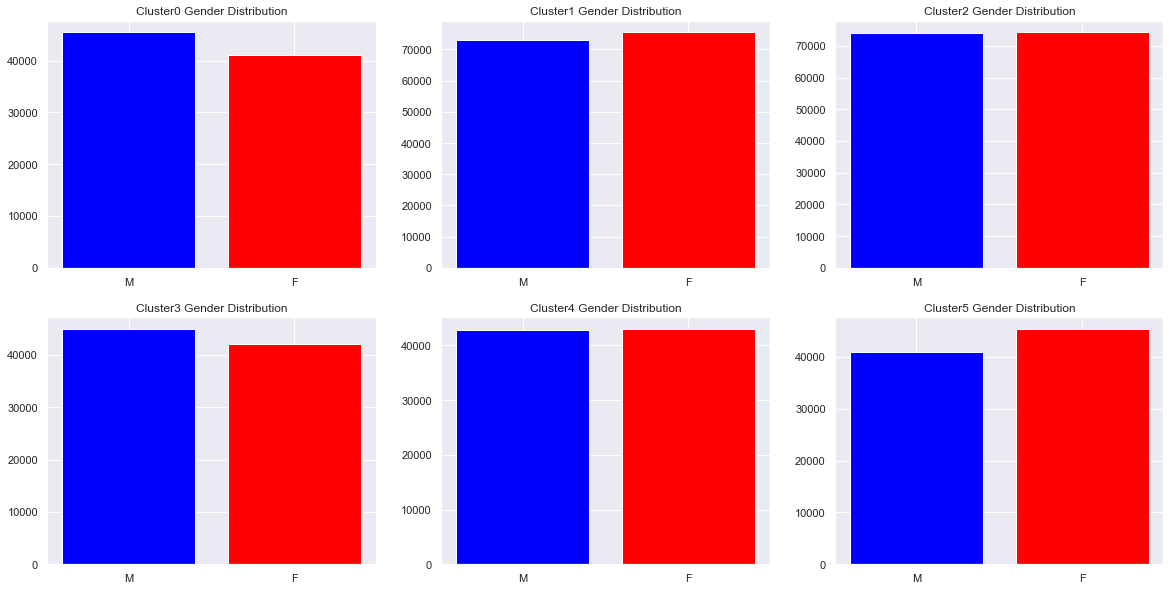

In [72]:
plt.figure(figsize=(20,10))

n1 = np.arange(2)
c0_genders = [45436,41010]
c1_genders = [73139,75457]
c2_genders = [74088,74229]
c3_genders = [44939,42146]
c4_genders = [42735,42990]
c5_genders = [40832,45362]

plt.subplot(2,3,1)
plt.bar(n1, c0_genders, color=("blue","red"))
plt.xticks(n1, ('M', 'F'))
plt.title('Cluster0 Gender Distribution')

plt.subplot(2,3,2)
plt.bar(n1, c1_genders, color=("blue","red"))
plt.xticks(n1, ('M', 'F'))
plt.title('Cluster1 Gender Distribution')

plt.subplot(2,3,3)
plt.bar(n1, c2_genders, color=("blue","red"))
plt.xticks(n1, ('M', 'F'))
plt.title('Cluster2 Gender Distribution')

plt.subplot(2,3,4)
plt.bar(n1, c3_genders, color=("blue","red"))
plt.xticks(n1, ('M', 'F'))
plt.title('Cluster3 Gender Distribution')

plt.subplot(2,3,5)
plt.bar(n1, c4_genders, color=("blue","red"))
plt.xticks(n1, ('M', 'F'))
plt.title('Cluster4 Gender Distribution')

plt.subplot(2,3,6)
plt.bar(n1, c5_genders, color=("blue","red"))
plt.xticks(n1, ('M', 'F'))
plt.title('Cluster5 Gender Distribution')

plt.show()

- Our clustering solution is not doing a good job of classifying our target variable, gender.  In fact, gender appears relatively equally distributed in each cluster.  The custers show an interesting uniformity in size as well: two of them contain ~ 150,000 entries, and the other 4 are each ~ 85,000 entries. Let's see how the clusters organized the 'group' variable.

In [71]:
print('Comparing k-means clusters against the group data:')
print(pd.crosstab(y_2_train, labels))

Comparing k-means clusters against the group data:
col_0          0      1      2      3      4      5
group_num                                          
0           5266   7805   8713   4289   3950   5160
1           5816   8866  11491   4498   4136   7466
2           8286  15358  14243   8769   8956   9127
3           6532  13680  12067   7671   8548   7270
4           4830   8110   8324   4547   4720   4876
5           4544   7449   7993   4494   3843   4184
6          10280  21638  19391  12372  12680  11463
7           7931  12153  12836   7267   6887   6927
8           2849   5592   4753   3311   3132   2701
9          11084  17963  17368  11396  12152  10963
10         12598  18506  20496  11381  10786  10777
11          6430  11476  10642   7090   5935   5280


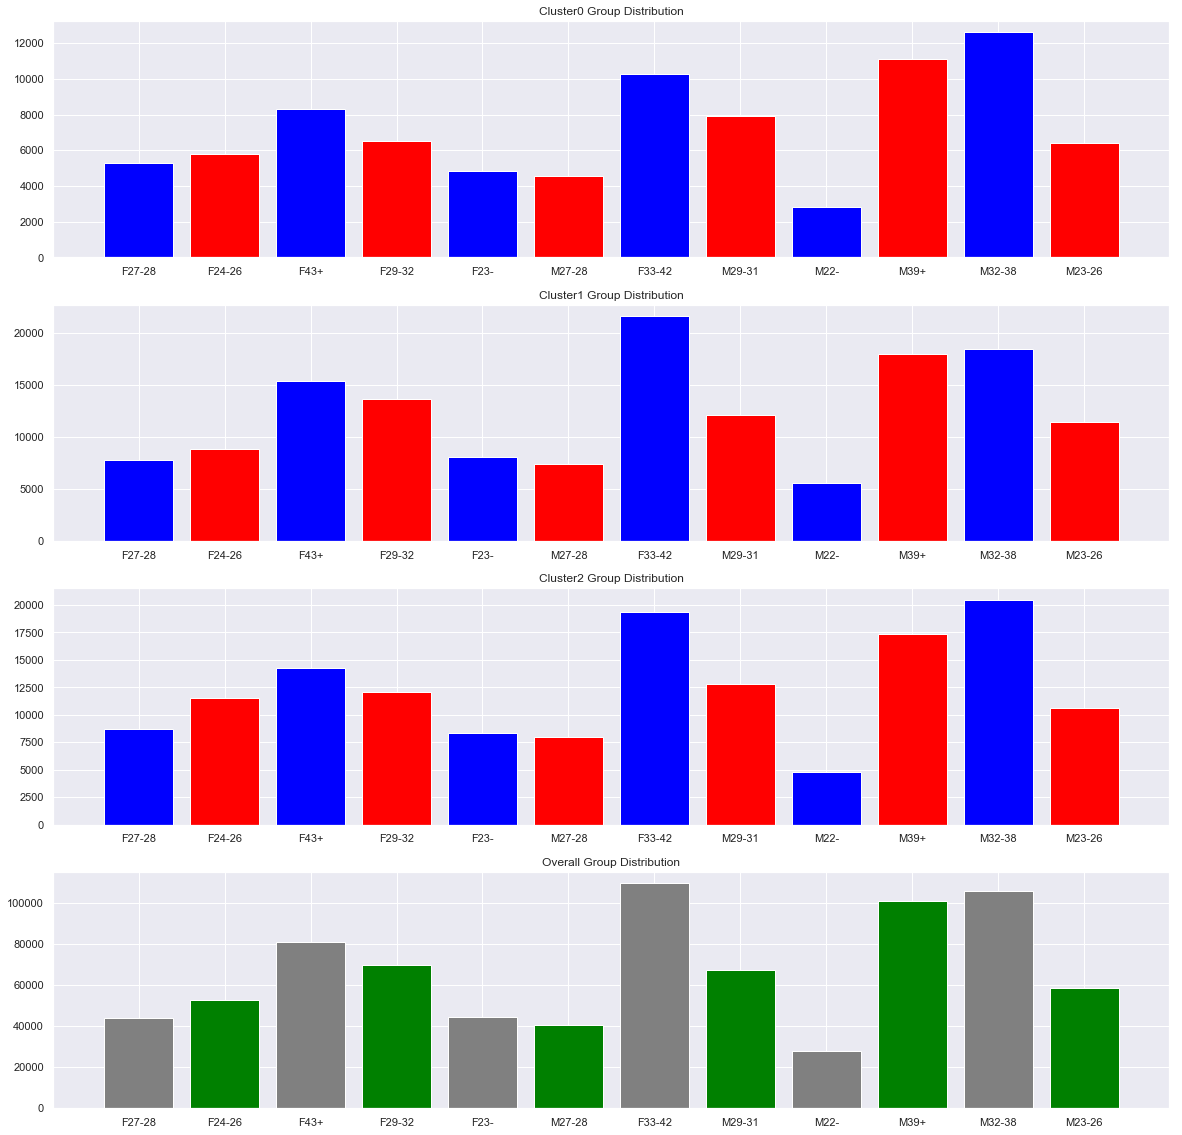

In [92]:
plt.figure(figsize=(20,20))

n1 = np.arange(12)
c0_groups = [5266,5816,8286,6532,4830,4544,10280,7931,2849,11084,12598,6430]
c1_groups = [7805,8866,15358,13680,8110,7449,21638,12153,5592,17963,18506,11476]
c2_groups = [8713,11491,14243,12067,8324,7993,19391,12836,4753,17368,20496,10642]

plt.subplot(4,1,1)
plt.bar(n1, c0_groups, color=("blue","red"))
plt.xticks(n1, ('F27-28', 'F24-26','F43+','F29-32','F23-','M27-28','F33-42','M29-31','M22-','M39+','M32-38','M23-26'))
plt.title('Cluster0 Group Distribution')

plt.subplot(4,1,2)
plt.bar(n1, c1_groups, color=("blue","red"))
plt.xticks(n1, ('F27-28', 'F24-26','F43+','F29-32','F23-','M27-28','F33-42','M29-31','M22-','M39+','M32-38','M23-26'))
plt.title('Cluster1 Group Distribution')

plt.subplot(4,1,3)
plt.bar(n1, c2_groups, color=("blue","red"))
plt.xticks(n1, ('F27-28', 'F24-26','F43+','F29-32','F23-','M27-28','F33-42','M29-31','M22-','M39+','M32-38','M23-26'))
plt.title('Cluster2 Group Distribution')

plt.subplot(4,1,4)
plt.bar(n1, (len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'F27-28']),
             len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'F24-26']),
             len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'F43+']),
             len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'F29-32']),
             len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'F23-']),
             len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'M27-28']),
             len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'F33-42']),
             len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'M29-31']),
             len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'M22-']),
             len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'M39+']),
             len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'M32-38']),
             len(df_smaller_downsampled.loc[df_smaller_downsampled['group'] == 'M23-26'])), color=("grey","green"))
plt.xticks(n1, ('F27-28', 'F24-26','F43+','F29-32','F23-','M27-28','F33-42','M29-31','M22-','M39+','M32-38','M23-26'))
plt.title('Overall Group Distribution')

plt.show()

- Our clustering model is not finding meaningful discrimination patterns in the data with respect to the 'group' variable, either.  The distribution of the 'group' variable in each cluster closely matches the distribution of the 'group' variable in general, as shown in the histograms above.

## Model 7: CNN

- We're still learning how to use neural networks, but we're so excited about them that we wanted to try one here.  Unfortunately, we weren't able to get it to train very well on this data.

In [93]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

from keras import backend as K

In [94]:
X_cnn = df_smaller_downsampled[['device_id', 'app_id', 'is_active', 'label_id', 'event_id', 
                            'haversine_distance', 'time_hour']]
X_norm_cnn = normalize(X_cnn)

In [103]:
#Split the data into training and testing sets
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_norm_cnn,
    y,
    test_size=0.2,
    random_state=42)

In [104]:
#Shaping the data for the network
y_train_cnn2 = keras.utils.to_categorical(y_train_cnn)
y_test_cnn2 = keras.utils.to_categorical(y_test_cnn)

X_train_cnn2 = X_train_cnn.reshape(X_train_cnn.shape[0], 1, 7)
X_test_cnn2 = X_test_cnn.reshape(X_test_cnn.shape[0], 1, 7)

In [97]:
#Building the model
model = Sequential()

model.add(Conv1D(filters=1, kernel_size=1, 
                 input_shape=(1,7),kernel_initializer= 'uniform',      
                  activation= 'relu'))
#model.add(MaxPooling1D(pool_size=(1)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 1)              8         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 522
Trainable params: 522
Non-trainable params: 0
________________________________________________________

In [98]:
#Fitting the model
model.fit(X_train_cnn2, y_train_cnn2,
          epochs=10,
          verbose=1,
          validation_data=(X_test_cnn2, y_test_cnn2))
score = model.evaluate(X_test_cnn2, y_test_cnn2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 642363 samples, validate on 160591 samples
Epoch 1/10
642363/642363 [==============================] - 34s 54us/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch 2/10
642363/642363 [==============================] - 34s 52us/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch 3/10
642363/642363 [==============================] - 33s 51us/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.4989
Epoch 4/10
642363/642363 [==============================] - 32s 49us/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4989
Epoch 5/10
642363/642363 [==============================] - 32s 49us/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6933 - val_accuracy: 0.5011
Epoch 6/10
642363/642363 [==============================] - 31s 48us/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 7/10
642363/642363 [======================

In [100]:
y_preds_cnn = model.predict(X_test_cnn2)

In [115]:
y_preds_cnn2 = keras.utils.to_categorical(y_preds_cnn)

In [139]:
#classification report
print(classification_report(y_test_cnn, y_preds_cnn2[:,0], labels=None, target_names=None, 
                       sample_weight=None, digits=2, output_dict=False
                      ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     80477
           1       0.50      1.00      0.67     80114

    accuracy                           0.50    160591
   macro avg       0.25      0.50      0.33    160591
weighted avg       0.25      0.50      0.33    160591



- This relatively simple neural network is not doing a great job of classifying the target variable, as shown above by the classification report.  In fact, its performance is about the same as guessing, since the target variable classes are balanced 1:1, and the network's accuracy is ~ 0.51.

## Summary and Conclusions

- We set out on this project wondering if it was possible to classify gender based on a large set of app usage data.  After data exploration, a series of join operations, downsampling, and some clever feature engneering, we were finally able to try some models.  
- The best performing model by far was the Random Forest Classifier, followed by the KNN model.  None of the other models showed good enough classification performance to be considered.  We suspected from the beginning that the RFC model would be one of the best performers: they make no assumptions about data shape or type, and they are known for being excellent classifying solutions.  
- As a product, this model could be included in a suite of models designed to construct a sort of digital avatar of a user, enabling marketing teams to customize their offerings to specific users.  
- To maintain and improve the model, the best strategies would be to feed the model more data, and to move it to a more powerful computing envionment.  We would also like to try it as a classifier for other user characteristics to improve its value as a product.

## Appendix

In [34]:
#Here is our haversine distance function
from math import radians, cos, sin, asin, sqrt

def haversine_to_origin(lat, lng, degrees=True):
    # radius of earth in km
    r = 6371 

    # Convert degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # Haversine formula expressed as distance to lat-long origin (0,0)
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d